# Environment Set-up

In [ ]:
%%pip_requirements shap numpy==1.21.6

cloudpickle==2.2.1
importlib-metadata==6.0.0
joblib==1.2.0
llvmlite==0.39.1
numba==0.56.4
numpy==1.21.6
packaging==23.0
pandas==1.5.3
python-dateutil==2.8.2
pytz==2022.7.1
scikit-learn==1.2.2
scipy==1.10.1
setuptools==67.6.0
shap==0.41.0
six==1.16.0
slicer==0.0.7
threadpoolctl==3.1.0
tqdm==4.65.0
zipp==3.15.0

In [3]:
import shap

In [ ]:
%%pip_requirements dfply plotly plotnine Jinja2 lightgbm

backports.zoneinfo==0.2.1
cloudpickle==2.2.1
contourpy==1.0.7
cycler==0.11.0
dfply==0.3.3
fonttools==4.39.0
importlib-metadata==6.0.0
importlib-resources==5.12.0
Jinja2==3.1.2
joblib==1.2.0
kiwisolver==1.4.4
lightgbm==3.3.5
llvmlite==0.39.1
MarkupSafe==2.1.2
matplotlib==3.7.1
mizani==0.8.1
numba==0.56.4
numpy==1.24.2
packaging==23.0
palettable==3.3.0
pandas==1.5.3
patsy==0.5.3
Pillow==9.4.0
plotly==5.13.1
plotnine==0.10.1
pyparsing==3.0.9
python-dateutil==2.8.2
pytz==2022.7.1
scikit-learn==1.2.2
scipy==1.10.1
setuptools==67.6.0
shap==0.41.0
six==1.16.0
slicer==0.0.7
statsmodels==0.13.5
tenacity==8.2.2
threadpoolctl==3.1.0
tqdm==4.65.0
wheel==0.38.4
zipp==3.15.0

In [5]:
import warnings
#warnings.simplefilter(action='error', category=FutureWarning)
warnings.filterwarnings('ignore')

In [8]:
from vintools.spark import *

import pandas as pd
import numpy as np
import pyspark.sql.functions as sf
from pyspark.sql.window import Window

from dfply import * 
import matplotlib.pyplot as plt
from plotnine import * # plotting library that mimics ggplot2 in R
import seaborn as sns
from datetime import datetime, timedelta

import scipy.stats as stats
import statsmodels.formula.api as smf

from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from statsmodels.stats.rates import test_poisson_2indep

import lightgbm as lgb
from sklearn.model_selection import train_test_split, RepeatedKFold

from statsmodels.genmod.families import Poisson

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn import metrics #roc_auc_score, roc_curve,mean_squared_error, mean_absolute_error 

import plotly.graph_objects as go
from tqdm.notebook import tqdm

In [9]:
conversion_days=14
START_DATE = "2022-06-01 00:00:00"
END_DATE = (datetime.strptime(START_DATE, "%Y-%m-%d %H:%M:%S")+timedelta(days=1)).strftime("%Y-%m-%d %H:%M:%S")
LIMIT_DATE = (datetime.strptime(END_DATE, "%Y-%m-%d %H:%M:%S")+timedelta(days=conversion_days)).strftime("%Y-%m-%d %H:%M:%S")

RETAIN_START_DATE = (datetime.strptime(START_DATE, "%Y-%m-%d %H:%M:%S")+timedelta(days=60)).strftime("%Y-%m-%d %H:%M:%S")
RETAIN_LIMIT_DATE = (datetime.strptime(END_DATE, "%Y-%m-%d %H:%M:%S")+timedelta(days=120)).strftime("%Y-%m-%d %H:%M:%S")


#test_name = "wallet_activation_name_split"
#ttest_id =  [14375, 14376,  14377,  14378, 14379, 14380, 14381]
seed = 202303

In [10]:
ss = SparkSessionBuilder(Tier.XXL).build()

In [11]:
PORTALS = ['fr']
context = QueryContext(ss, portals = PORTALS)

In [12]:
# show all columns, when display pandas DataFrame
pd.set_option('display.max_columns', None)

# Generate Cohort

In [8]:
txs = (context.readHiveTable('enriched_facts', 'sale')
       # filter transactions that end within a defined time period
       .withColumn("completed_utc_time", sf.to_utc_timestamp(sf.from_unixtime(sf.col("completed_utc_unixtime")),"UTC"))
       .withColumn("tx_end_utc_time", sf.when(sf.col("completed_utc_time").isNull(), sf.col('cancelled_at'))
                   .otherwise(sf.col("completed_utc_time")))
       .filter((sf.col("tx_end_utc_time") >= START_DATE) & (sf.col("tx_end_utc_time") < END_DATE))
       
       .filter((sf.col("selling_way") == "Payment") 
               & (sf.col('portal').isin(PORTALS))
               & (sf.col('seller_is_suspicious_account')!=1) # remove suspicious accounts 
               #we no longer need this? .filter(sf.col('seller_account_status').isin(['Active', 'Unconfirmed']))
               #"""Is Suspicious Account is equal to 1, if account is banned or shadow banned, 
               # was banned before deletion or ip suspiciousness is more than 0.5. In the future 
               # this indicator will be changed to always reflect our best estimate of suspiciousness. 
               # However, it won’t require any technical changes from your side.
               # """
               #& (sf.col('is_completed'))
               & (sf.col('suspended_at').isNull()) # should we exclude suspended txs?
               & (sf.col('disputed_at').isNull()) # should we exclude disputed txs?
              )
       .withColumn("is_integrated", 
                   sf.when(sf.col("package_size_code")
                           .isin(["SMALL", 
                                  "MEDIUM", 
                                  "LARGE", 
                                  "HEAVY_SMALL",
                                  "HEAVY_MEDIUM", 
                                  "HEAVY_LARGE"]),
                           sf.lit(1)).otherwise(sf.lit(0)))
       .filter((sf.col('carrier')!='CUSTOM') 
               & (sf.col('is_integrated')==1) # keep only users who used integrated shipping
              )
       .sort(sf.col("tx_end_utc_time").desc())
      )

print(txs.count())
print(txs.filter(sf.col('cancelled_at').isNotNull() & sf.col('completed_utc_time').isNotNull()).count())
print(txs.filter(sf.col('cancelled_at').isNotNull() & sf.col('completed_utc_time').isNotNull()).count()/txs.count())
print(txs.dropDuplicates(subset=['seller_global_user_id']).count())

941411
1195
0.001269371188566949
753275


In [9]:
tx_cohort = (txs
             .filter((sf.col('cancelled_at').isNull() & sf.col('completed_utc_time').isNotNull())
                     | (sf.col('cancelled_at').isNotNull() & sf.col('completed_utc_time').isNull()))
             .dropDuplicates(subset=['seller_global_user_id']) # keep last tx per user
             .withColumnRenamed('seller_id','user_id')
             .select('user_id','portal','tx_end_utc_time','seller_country_code', 'sale_platform', 'payment_provider')
             .cache()
            )
tx_cohort.count()

752674

# Generate Analytics Dataset

In [10]:
###############
# Listings
listings = (context.readHiveTable('enriched_facts','listing')
             .select("portal", "user_id", 'utc_time','id', 'gmv_eur_fixed', 'days_to_sell')
            .filter((sf.col('utc_time')>START_DATE) & (sf.col('utc_time')<LIMIT_DATE))
            )

tx_list = (tx_cohort.join(listings,['user_id', 'portal'],'left')
            .withColumn('utc_time', sf.when(sf.col('utc_time')<sf.col('tx_end_utc_time'), sf.lit(None)).otherwise(sf.col('utc_time')))
            .withColumn('gmv_eur_fixed', sf.when(sf.col('utc_time')<sf.col('tx_end_utc_time'), sf.lit(0)).otherwise(sf.col('gmv_eur_fixed')))
            .withColumn('utc_time',sf.when(sf.datediff(sf.col('utc_time'),sf.col('tx_end_utc_time'))>conversion_days,sf.lit(None)).otherwise(sf.col('utc_time')))
            .withColumn('gmv_eur_fixed',sf.when(sf.datediff(sf.col('utc_time'),sf.col('tx_end_utc_time'))>conversion_days,sf.lit(None)).otherwise(sf.col('gmv_eur_fixed')))
            
            .sort(sf.col('user_id'),sf.col('utc_time').asc())
            .dropDuplicates(subset=['user_id','utc_time'])
            
            .filter((sf.datediff(sf.col('utc_time'),sf.col('tx_end_utc_time'))<=conversion_days) | (sf.col('utc_time').isNull()))
            
            # metrics
            .withColumn('listed',sf.when(sf.col('utc_time').isNotNull(),sf.lit(1)).otherwise(sf.lit(0)))
            .withColumn('listed',sf.max(sf.col('listed')).over(Window.partitionBy('user_id','portal')))
            
            .withColumn('listings_per_lister', sf.approx_count_distinct(sf.col('utc_time')).over(Window.partitionBy('user_id','portal')))
            .withColumn('listings_per_lister', sf.when(sf.col('listed')==0,sf.lit(0)).otherwise(sf.col('listings_per_lister')))
            
            .withColumn('list_GMV', sf.sum(sf.col('gmv_eur_fixed')).over(Window.partitionBy('user_id','portal')))
            .withColumn('list_GMV', sf.when(sf.col('listed')==0,sf.lit(0)).otherwise(sf.col('list_GMV')))
            
            .dropDuplicates(subset=['user_id','portal'])
           )

###############
# Sales
sales = (context.readHiveTable('enriched_facts', 'sale')
  .filter((sf.col("utc_time") >= START_DATE) & (sf.col("utc_time") < LIMIT_DATE))
  .filter((sf.col("selling_way") == "Payment") & (sf.col('portal').isin(PORTALS)))
  .filter((sf.col('cancelled_at').isNull()))       
  .select("seller_id",'portal', "transaction_id", 'item_id', 'utc_time', 'gmv_eur_fixed') 
  .dropDuplicates(subset = ["transaction_id",'seller_id', 'portal'])
  .withColumnRenamed('utc_time', 'sale_utc_time')
  .withColumnRenamed('seller_id', 'user_id')
                   )

tx_sell = (tx_cohort
          .join(sales, ['user_id', 'portal'], 'left')
          .withColumn('sale_utc_time', sf.when(sf.col('sale_utc_time')<sf.col('tx_end_utc_time'), sf.lit(None)).otherwise(sf.col('sale_utc_time')))
          .withColumn('gmv_eur_fixed', sf.when(sf.col('sale_utc_time')<sf.col('tx_end_utc_time'), sf.lit(0)).otherwise(sf.col('gmv_eur_fixed')))
          .withColumn('sale_utc_time', sf.when(sf.datediff(sf.col('sale_utc_time'),sf.col('tx_end_utc_time'))>conversion_days, sf.lit(None)).otherwise(sf.col('sale_utc_time')))
          .withColumn('gmv_eur_fixed', sf.when(sf.datediff(sf.col('sale_utc_time'),sf.col('tx_end_utc_time'))>conversion_days, sf.lit(0)).otherwise(sf.col('gmv_eur_fixed')))
          
          .dropDuplicates(subset=['user_id','sale_utc_time'])
             
          .withColumn('sold', sf.when(sf.col('sale_utc_time').isNotNull(),sf.lit(1)).otherwise(sf.lit(0)))
          .withColumn('sold', sf.max(sf.col('sold')).over(Window.partitionBy('user_id','portal')))
          
          .withColumn('sales_per_seller', sf.approx_count_distinct(sf.col('sale_utc_time')).over(Window.partitionBy('user_id','portal')))
            
          .withColumn('sales_per_seller', sf.when(sf.col('sold')==0,sf.lit(0)).otherwise(sf.col('sales_per_seller')))
            
          .withColumn('sold_pGMV', sf.sum(sf.col('gmv_eur_fixed')).over(Window.partitionBy('user_id','portal'))) 
          .withColumn('sold_pGMV', sf.when(sf.col('sold')==1,sf.col('sold_pGMV')).otherwise(sf.lit(0)))
           
           .dropDuplicates(subset = ["user_id",'portal'])
          )
  
###############
# Buying  
buy = (context.readHiveTable('enriched_facts', 'sale')
  .filter((sf.col("utc_time") >= START_DATE) & (sf.col("utc_time") < LIMIT_DATE))
  .filter((sf.col("selling_way") == "Payment") & (sf.col('portal').isin(PORTALS)))
  .select("buyer_id", "transaction_id", 'item_id', 'portal', 'utc_time','gmv_eur_fixed')
  .dropDuplicates(subset = ["transaction_id", 'portal', 'buyer_id'])
  .withColumnRenamed('utc_time', 'sale_utc_time')
  .withColumnRenamed('buyer_id', 'user_id')
                   )

tx_buy = (tx_cohort
          .join(buy, ['user_id', 'portal'], 'left')
           .sort(sf.col('user_id'),sf.col('sale_utc_time').asc())
           .withColumn('sale_utc_time',sf.when(sf.datediff(sf.col('sale_utc_time'),sf.col('tx_end_utc_time'))>conversion_days,sf.lit(None)).otherwise(sf.col('sale_utc_time')))
           .withColumn('gmv_eur_fixed',sf.when(sf.datediff(sf.col('sale_utc_time'),sf.col('tx_end_utc_time'))>conversion_days,sf.lit(0)).otherwise(sf.col('gmv_eur_fixed')))
           .withColumn('sale_utc_time', sf.when(sf.col('sale_utc_time')<sf.col('tx_end_utc_time'), sf.lit(None)).otherwise(sf.col('sale_utc_time')))
           .withColumn('gmv_eur_fixed', sf.when(sf.col('sale_utc_time')<sf.col('tx_end_utc_time'), sf.lit(0)).otherwise(sf.col('gmv_eur_fixed')))
          
          .dropDuplicates(subset=['user_id','sale_utc_time'])
          
          .withColumn('bought', sf.when(sf.col('sale_utc_time').isNotNull(),sf.lit(1)).otherwise(sf.lit(0)))
          .withColumn('bought', sf.max(sf.col('bought')).over(Window.partitionBy('user_id','portal')))
          
          .withColumn('items_bought_per_seller', sf.approx_count_distinct(sf.col('item_id')).over(Window.partitionBy('user_id','portal')))
           
          .withColumn('items_bought_per_seller', sf.when(sf.col('bought')==0,sf.lit(0)).otherwise(sf.col('items_bought_per_seller')))
           
          .withColumn('bought_pGMV', sf.sum(sf.col('gmv_eur_fixed')).over(Window.partitionBy('user_id','portal')))
          .withColumn('bought_pGMV', sf.when(sf.col('bought_pGMV')>0,sf.col('bought_pGMV')).otherwise(sf.lit(0)))
           .dropDuplicates(subset = ["user_id",'portal'])
           )

###############
# Favorite Items
favorite_item = (context.readHiveTable("enriched_facts", "item_favorite")
  .filter(sf.col("portal").isin(PORTALS))
  .filter(sf.col("event")=="favorite_item")
  .filter((sf.col("utc_time") >= START_DATE) & (sf.col("utc_time") < LIMIT_DATE))
  .withColumnRenamed('favoriter_id','user_id')
  .select('user_id','portal','utc_time','item_id')
  .dropDuplicates(subset=['user_id','portal','item_id'])               
                )

favored_items = (tx_cohort
                 .join(favorite_item,['user_id', 'portal'],'left')
            .withColumn('utc_time', sf.when(sf.col('utc_time')<sf.col('tx_end_utc_time'), sf.lit(None)).otherwise(sf.col('utc_time')))
            .withColumn('utc_time',sf.when(sf.datediff(sf.col('utc_time'),sf.col('tx_end_utc_time'))>conversion_days,sf.lit(None)).otherwise(sf.col('utc_time')))
            .withColumn('item_id', sf.when(sf.col('utc_time')<sf.col('tx_end_utc_time'), sf.lit(None)).otherwise(sf.col('item_id')))
            .withColumn('item_id',sf.when(sf.datediff(sf.col('utc_time'),sf.col('tx_end_utc_time'))>conversion_days,sf.lit(None)).otherwise(sf.col('item_id')))
            
            .dropDuplicates(subset=['user_id','utc_time','item_id'])
            
            .withColumn('favored',sf.when(sf.col('item_id').isNotNull(),sf.lit(1)).otherwise(sf.lit(0)))
            .withColumn('favored',sf.max(sf.col('favored')).over(Window.partitionBy('user_id','portal')))
            
            .withColumn('favorites_per_lister', sf.approx_count_distinct(sf.col('item_id')).over(Window.partitionBy('user_id','portal')))
            .withColumn('favorites_count', sf.when(sf.col('favored')==0,sf.lit(0)).otherwise(sf.col('favorites_per_lister')))
            
            .dropDuplicates(subset=['user_id','portal'])
           )
            
###############  
# Visits / Active days
dailyVisits = (context.readHiveTable("batch_views", "daily_active_users")
  .filter(sf.col("portal").isin(PORTALS))
  .filter((sf.col("utc_time") >= START_DATE) & (sf.col("utc_time") < LIMIT_DATE))
  .withColumn("visit_date",sf.to_date("utc_time"))
  .select("user_id", "portal", "visit_date")
  .distinct()
              )

active_users = (tx_cohort
                .join(dailyVisits,['user_id', 'portal'],'left')
            .withColumn('visit_date', sf.when(sf.col('visit_date')<sf.col('tx_end_utc_time'), sf.lit(None)).otherwise(sf.col('visit_date')))
            .withColumn('visit_date',sf.when(sf.datediff(sf.col('visit_date'),sf.col('tx_end_utc_time'))>conversion_days,sf.lit(None)).otherwise(sf.col('visit_date')))
            
            .dropDuplicates(subset=['user_id','visit_date'])
            
            .withColumn('active',sf.when(sf.col('visit_date').isNotNull(),sf.lit(1)).otherwise(sf.lit(0)))
            .withColumn('active',sf.max(sf.col('active')).over(Window.partitionBy('user_id','portal')))
            
            .withColumn('active_days', sf.approx_count_distinct(sf.col('visit_date')).over(Window.partitionBy('user_id','portal')))
            .withColumn('active_days', sf.when(sf.col('active')==0,sf.lit(0)).otherwise(sf.col('active_days')))
                
            .dropDuplicates(subset=['user_id','portal'])
            )

###############
# Item Impressions
impressions = (context.readHiveTable("enriched_facts", "item_impression")
  .filter((sf.col("utc_time") >= START_DATE) & (sf.col("utc_time") < LIMIT_DATE))
  .filter(sf.col("portal").isin(PORTALS))
  .select('user_id','portal','utc_time','item_id')
  .dropDuplicates(subset=['user_id','portal','utc_time','item_id'])               
                )

impression_count = (tx_cohort
                    .join(impressions,['user_id', 'portal'],'left')
            .withColumn('utc_time', sf.when(sf.col('utc_time')<sf.col('tx_end_utc_time'), sf.lit(None)).otherwise(sf.col('utc_time')))
            .withColumn('utc_time',sf.when(sf.datediff(sf.col('utc_time'),sf.col('tx_end_utc_time'))>conversion_days,sf.lit(None)).otherwise(sf.col('utc_time')))
            .withColumn('item_id', sf.when(sf.col('utc_time')<sf.col('tx_end_utc_time'), sf.lit(None)).otherwise(sf.col('item_id')))
            .withColumn('item_id',sf.when(sf.datediff(sf.col('utc_time'),sf.col('tx_end_utc_time'))>conversion_days,sf.lit(None)).otherwise(sf.col('item_id')))
            
            .dropDuplicates(subset=['user_id','utc_time','item_id'])
            
            .withColumn('impressed',sf.when(sf.col('item_id').isNotNull(),sf.lit(1)).otherwise(sf.lit(0)))
            .withColumn('impressed',sf.max(sf.col('impressed')).over(Window.partitionBy('user_id','portal')))
                    
            .withColumn('impressions_per_user', sf.approx_count_distinct(sf.col('item_id')).over(Window.partitionBy('user_id','portal')))
            .withColumn('impressions_count', sf.when(sf.col('impressed')==0,sf.lit(0)).otherwise(sf.col('impressions_per_user')))
             
            .dropDuplicates(subset=['user_id','portal'])
           )

In [11]:
analytics_data = (tx_cohort.select("portal", "user_id", 'tx_end_utc_time','seller_country_code', 'sale_platform', 'payment_provider')
                       #.join(retain_list.select('user_id','portal','retained_list'), ['user_id','portal'], 'left')
                       #.join(retain_buy.select('user_id','portal','retained_buy'), ['user_id','portal'], 'left')
                       #.withColumn('retained', sf.when((sf.col('retained_list')==1) | (sf.col('retained_buy')==1),sf.lit(1)).otherwise(sf.lit(0)))
                       .join(tx_list.select('user_id','portal','listings_per_lister','list_GMV','listed'), ['user_id','portal'], 'left')
                       .join(tx_buy.select('user_id','portal','items_bought_per_seller','bought_pGMV','bought'), ['user_id','portal'], 'left')
                       .join(tx_sell.select('user_id','portal','sales_per_seller','sold_pGMV','sold'), ['user_id','portal'], 'left')
                       .join(favored_items.select("portal", "user_id", 'favorites_count','favored'), ['user_id','portal'], 'left')
                       .join(active_users.select('user_id','portal','active_days'), ['user_id','portal'], 'left')
                       .join(impression_count.select('user_id','portal','impressed','impressions_count'), ['user_id','portal'], 'left')
                       )

In [12]:
analytics_data.saveAsHiveTable('mindaugasm','tx_retention_proxy')

In [13]:
analytics_data = context.readHiveTable('mindaugasm','tx_retention_proxy')

In [14]:
###############
# Listings
rlistings = (context.readHiveTable('enriched_facts','listing')
            .select("portal", "user_id", 'utc_time','id', 'gmv_eur_fixed', 'days_to_sell')
            .filter((sf.col('utc_time')>RETAIN_START_DATE) & (sf.col('utc_time')<RETAIN_LIMIT_DATE))
            )

retain_list = (analytics_data.join(rlistings,['user_id', 'portal'],'left')
            .withColumn('utc_time',sf.when(sf.datediff(sf.col('utc_time'),sf.col('tx_end_utc_time'))>120,sf.lit(None)).otherwise(sf.col('utc_time')))
            .withColumn('utc_time',sf.when(sf.datediff(sf.col('utc_time'),sf.col('tx_end_utc_time'))<60,sf.lit(None)).otherwise(sf.col('utc_time')))
            
            .dropDuplicates(subset=['user_id','utc_time'])
            
            # metrics
            .withColumn('listed',sf.when(sf.col('utc_time').isNotNull(),sf.lit(1)).otherwise(sf.lit(0)))
            .withColumn('retained_list',sf.max(sf.col('listed')).over(Window.partitionBy('user_id','portal')))
            
            .dropDuplicates(subset=['user_id','portal'])
           )
  
###############
# Buying  
rbuy = (context.readHiveTable('enriched_facts', 'sale')
  .filter((sf.col("utc_time") > RETAIN_START_DATE) & (sf.col("utc_time") < RETAIN_LIMIT_DATE))
  .filter((sf.col("selling_way") == "Payment") & (sf.col('portal').isin(PORTALS)))
  .select("buyer_id", "transaction_id", 'item_id', 'portal', 'utc_time','gmv_eur_fixed')
  .dropDuplicates(subset = ["transaction_id", 'portal', 'buyer_id'])
  .withColumnRenamed('utc_time', 'sale_utc_time')
  .withColumnRenamed('buyer_id', 'user_id')
                   )

retain_buy = (analytics_data.join(rbuy, ['user_id', 'portal'], 'left')
           .sort(sf.col('user_id'),sf.col('sale_utc_time').asc())
           .withColumn('sale_utc_time',sf.when(sf.datediff(sf.col('sale_utc_time'),sf.col('tx_end_utc_time'))>120,sf.lit(None)).otherwise(sf.col('sale_utc_time')))
           .withColumn('sale_utc_time',sf.when(sf.datediff(sf.col('sale_utc_time'),sf.col('tx_end_utc_time'))<60,sf.lit(None)).otherwise(sf.col('sale_utc_time')))
           
          .dropDuplicates(subset=['user_id','sale_utc_time'])
          
          .withColumn('bought', sf.when(sf.col('sale_utc_time').isNotNull(),sf.lit(1)).otherwise(sf.lit(0)))
          .withColumn('retained_buy', sf.max(sf.col('bought')).over(Window.partitionBy('user_id','portal')))
          
           .dropDuplicates(subset = ["user_id",'portal'])
           )

In [15]:
analytics_data = (analytics_data
                  .join(retain_list.select('user_id','portal','retained_list'), ['user_id','portal'], 'left')
                  .join(retain_buy.select('user_id','portal','retained_buy'), ['user_id','portal'], 'left')
                  .withColumn('retained', sf.when((sf.col('retained_list')==1) | (sf.col('retained_buy')==1),sf.lit(1)).otherwise(sf.lit(0)))
                 )

# Analysis

In [16]:
df =(analytics_data
     .sample(0.2, seed=seed)
     .select('retained',
             'listings_per_lister','list_GMV','listed',
             'items_bought_per_seller','bought_pGMV','bought',
             'sales_per_seller','sold_pGMV','sold',
             'favorites_count','favored',
             'impressed','impressions_count',
             'active_days')
     #.toPandas()
    )

df.count()

150665

In [17]:
df=df.toPandas().dropna()

In [18]:
df.describe()

,retained,listings_per_lister,list_GMV,listed,items_bought_per_seller,bought_pGMV,bought,sales_per_seller,sold_pGMV,sold,favorites_count,favored,impressed,impressions_count,active_days
count,136692.000000,136692.000000,136692.000000,136692.000000,136692.000000,136692.000000,136692.000000,136692.000000,136692.000000,136692.000000,136692.0,136692.0,136692.000000,136692.000000,136692.000000
mean,0.824723,9.565805,41.335180,0.542951,1.422512,18.233556,0.382817,3.406352,42.726612,0.661641,0.0,0.0,0.009766,48.353042,11.454913
std,0.380205,26.993839,123.571269,0.498154,3.533852,78.023696,0.486076,6.326855,112.112669,0.473153,0.0,0.0,0.098342,1008.989741,3.932168
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,10.000000
50%,1.000000,1.000000,4.370000,1.000000,0.000000,0.000000,0.000000,1.000000,10.000000,1.000000,0.0,0.0,0.000000,0.000000,13.000000
75%,1.000000,9.000000,35.000000,1.000000,1.000000,13.200000,1.000000,4.000000,40.474825,1.000000,0.0,0.0,0.000000,0.000000,14.000000
max,1.000000,2797.000000,6650.500000,1.000000,228.000000,11177.500000,1.000000,193.000000,7511.500000,1.000000,0.0,0.0,1.000000,107535.000000,15.000000


In [19]:
corrM = df.corr()

pd.options.display.float_format = '{:,.3f}'.format

corrM

,retained,listings_per_lister,list_GMV,listed,items_bought_per_seller,bought_pGMV,bought,sales_per_seller,sold_pGMV,sold,favorites_count,favored,impressed,impressions_count,active_days
retained,1.000,0.117,0.101,0.262,0.149,0.081,0.242,0.161,0.106,0.264,NaN,NaN,0.004,0.017,0.400
listings_per_lister,0.117,1.000,0.422,0.325,0.160,0.071,0.093,0.633,0.396,0.234,NaN,NaN,0.003,0.013,0.224
list_GMV,0.101,0.422,1.000,0.307,0.195,0.215,0.095,0.622,0.877,0.216,NaN,NaN,0.005,0.015,0.198
listed,0.262,0.325,0.307,1.000,0.184,0.102,0.215,0.394,0.286,0.560,NaN,NaN,0.003,0.020,0.511
items_bought_per_seller,0.149,0.160,0.195,0.184,1.000,0.522,0.511,0.228,0.210,0.165,NaN,NaN,0.000,0.053,0.245
bought_pGMV,0.081,0.071,0.215,0.102,0.522,1.000,0.297,0.125,0.227,0.090,NaN,NaN,-0.001,0.031,0.139
bought,0.242,0.093,0.095,0.215,0.511,0.297,1.000,0.151,0.103,0.208,NaN,NaN,0.007,0.044,0.391
sales_per_seller,0.161,0.633,0.622,0.394,0.228,0.125,0.151,1.000,0.686,0.385,NaN,NaN,0.004,0.018,0.325
sold_pGMV,0.106,0.396,0.877,0.286,0.210,0.227,0.103,0.686,1.000,0.273,NaN,NaN,0.005,0.015,0.226
sold,0.264,0.234,0.216,0.560,0.165,0.090,0.208,0.385,0.273,1.000,NaN,NaN,0.005,0.018,0.582


In [30]:
X = df[['listings_per_lister','list_GMV','listed',
             'items_bought_per_seller','bought_pGMV','bought',
             'sales_per_seller','sold_pGMV','sold',
             #'favorites_count','favored',
             #'impressed','impressions_count',
             'active_days']]
y = df['retained']
X=sm.add_constant(X)

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())



Optimization terminated successfully.
         Current function value: 0.380316
         Iterations 8
                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.181      
Dependent Variable:   retained           AIC:                103994.2629
Date:                 2023-03-09 11:13   BIC:                104102.3432
No. Observations:     136692             Log-Likelihood:     -51986.    
Df Model:             10                 LL-Null:            -63446.    
Df Residuals:         136681             LLR p-value:        0.0000     
Converged:            1.0000             Scale:              1.0000     
No. Iterations:       8.0000                                            
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
const                   -0.6062   0.0189 -32.1417 0

In [31]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=42)

logreg = LogisticRegression()
logreg.fit(x_train, y_train)

print('Training accuracy {:.4f}'.format(logreg.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(logreg.score(x_test,y_test)))

y_pred = logreg.predict(x_test)
print(metrics.confusion_matrix(y_test,y_pred))
print("Precision: ", metrics.precision_score(y_test,y_pred))
print("Recall: ", metrics.recall_score(y_test,y_pred))
tn, fp, fn, tp = metrics.confusion_matrix(y_test,y_pred).ravel()
print('tn',tn, 'fp',fp, 'fn',fn, 'tp',tp)

Training accuracy 0.8384
Testing accuracy 0.8378
[[ 1671  6153]
 [ 1165 36120]]
0.8544461003477397
0.9687541906933083
tn 1671 fp 6153 fn 1165 tp 36120


No Skill: ROC AUC=0.500
logreg: ROC AUC=0.793


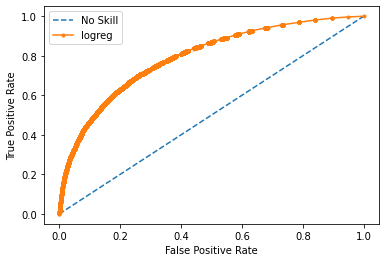

In [32]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = logreg.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
lr_auc = metrics.roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('logreg: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='logreg')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

[100]	training's binary_logloss: 0.367307	valid_0's binary_logloss: 0.377319
Training accuracy 0.8389
Testing accuracy 0.8387
[[ 1290  6534]
 [  743 36542]]
0.848314606741573
0.9800724151803675
tn 1290 fp 6534 fn 743 tp 36542


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

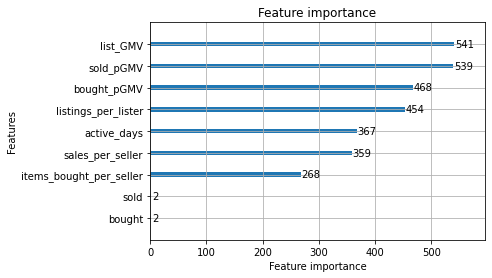

In [33]:
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],verbose=100,eval_metric='logloss')

print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

y_pred = model.predict(x_test)
print(metrics.confusion_matrix(y_test,y_pred))
print("Precision: ", metrics.precision_score(y_test,y_pred))
print("Recall: ", metrics.recall_score(y_test,y_pred))
tn, fp, fn, tp = metrics.confusion_matrix(y_test,y_pred).ravel()
print('tn',tn, 'fp',fp, 'fn',fn, 'tp',tp)

lgb.plot_importance(model)

In [34]:
# compute SHAP values
explainer = shap.TreeExplainer(model, x_test)
shap_values = explainer(x_test)

 99%|===================| 44815/45109 [01:31<00:00]        

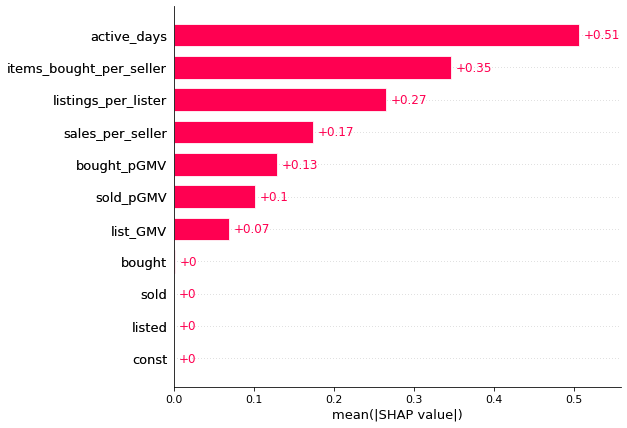

In [35]:
shap.plots.bar(shap_values, max_display=20)

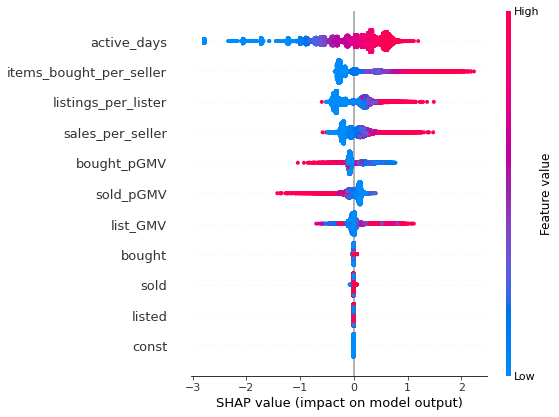

In [36]:
#shap_values = shap.TreeExplainer(model).shap_values(X_test) 
shap.summary_plot(shap_values, x_test)

No Skill: ROC AUC=0.500
lgbm: ROC AUC=0.793


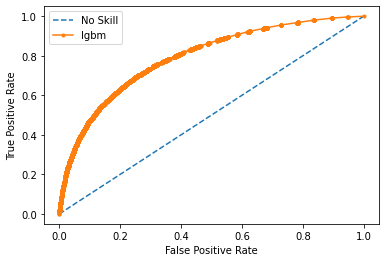

In [37]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
lr_auc = metrics.roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('lgbm: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='lgbm')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()